### Rain in Australia
Importacions de les llibrerias utilitzades

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ipywidgets as widgets
import plotly.express as px

from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_recall_curve, average_precision_score, \
    roc_auc_score, roc_curve, auc, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns
import scipy.stats
from scipy import stats
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from xgboost import XGBClassifier

import time

pd.set_option("display.max_columns", None)


In [3]:
database = pd.read_csv('../../data/weatherAUS.csv')

database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [ ]:
database.head()

In [33]:
database.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
count,219576.000000,220186.000000,217610.000000,125611.000000,115920.000000,205467.000000,218474.000000,216363.000000,217626.000000,214716.000000,198985.000000,199014.000000,139617.000000,135317.000000,219029.000000,216136.000000,220632.000000
mean,12.567010,22.507646,3.686573,5.152924,6.495952,42.080485,14.548981,19.164173,72.074518,57.630139,1016.480622,1014.187103,5.047143,5.188882,16.905043,20.830710,0.500000
std,6.406745,7.113965,11.081715,3.971010,3.938340,14.649693,9.194418,9.203860,18.579181,21.843489,7.340725,7.281825,2.776560,2.618237,6.464428,6.937084,0.500001
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,8.000000,17.200000,0.000000,2.400000,3.100000,31.000000,7.000000,13.000000,60.000000,42.000000,1011.600000,1009.300000,2.000000,3.000000,12.200000,15.700000,0.000000
50%,12.300000,21.800000,0.000000,4.400000,6.800000,39.000000,13.000000,19.000000,74.000000,58.000000,1016.500000,1014.100000,6.000000,6.000000,16.500000,20.200000,0.500000
75%,17.300000,27.500000,2.200000,7.000000,9.900000,50.000000,20.000000,24.000000,87.000000,73.000000,1021.400000,1019.100000,7.000000,7.000000,21.500000,25.500000,1.000000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,1.000000


In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(database.isnull(), yticklabels = False, cbar=False, cmap='gray')

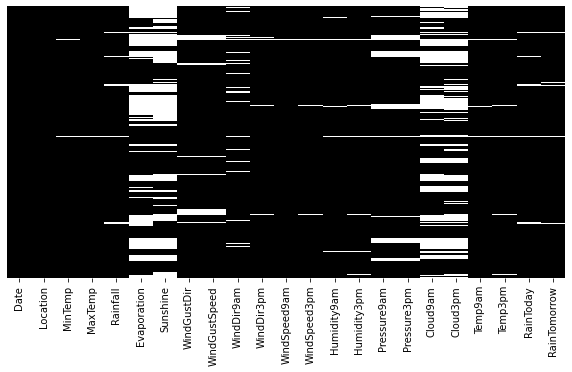

In [35]:
# Checking data for NaN
missing = pd.DataFrame(database.isnull().sum().sort_values(ascending=False), columns=['No. of missing values'])
missing['% missing_values'] = (missing/len(database)).round(2)*100
missing

,No. of missing values,% missing_values
Sunshine,104712,47.0
Evaporation,95021,43.0
Cloud3pm,85315,39.0
Cloud9am,81015,37.0
Pressure9am,21647,10.0
Pressure3pm,21618,10.0
WindGustDir,15286,7.0
WindGustSpeed,15165,7.0
WindDir9am,14803,7.0
WindDir3pm,6334,3.0


In [ ]:
# num_col = [num_col for num_col in database.columns if database[num_col].dtype !="O"] 
# num_col_with_null_values = [col for col in num_col if database[col].isnull().sum()]
continuous_cols = list(database.select_dtypes(include=['float64']).columns)
plt.figure(figsize=(12,10))
database.boxplot(continuous_cols,rot = 90)

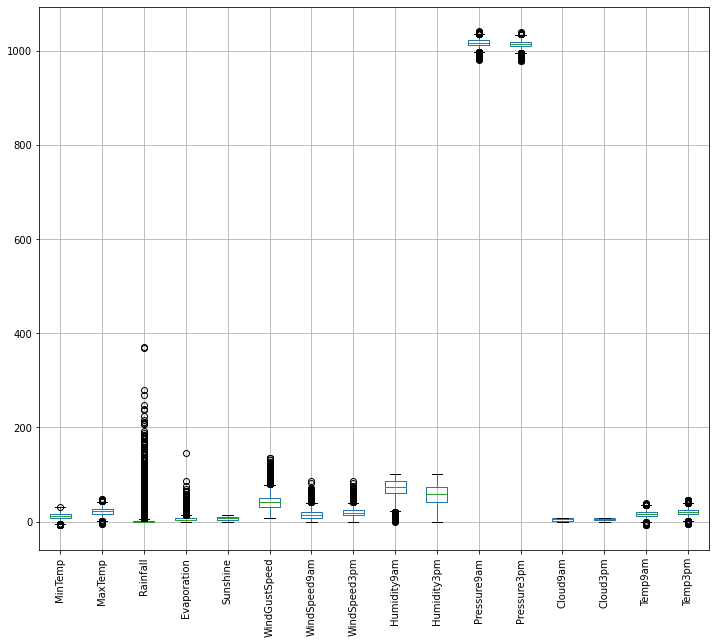

In [36]:
database.duplicated().sum()

79506

In [37]:
database['RainTomorrow'].value_counts()

0    110316
1    110316
Name: RainTomorrow, dtype: int64

In [4]:
targetNulls = widgets.ToggleButtons(
    options=['No', 'Yes', 'Delete'],
    description='Optios:',
    disabled=False,
    tooltips=['No', 'Yes', 'Delete']
)
display(targetNulls)
    
def changeValues(obj):
    database = pd.read_csv('../../data/weatherAUS.csv')
    if(targetNulls.value == 'No'):
        database['RainTomorrow'] = [1 if i=='Yes' else 0 for i in database['RainTomorrow'] ]
    elif(targetNulls.value == 'Yes'):
        database['RainTomorrow']=[0 if i=='No' else 1 for i in database['RainTomorrow'] ]
    else:
        database = database.dropna(axis=0, subset=['RainTomorrow'])
    print("Opcio escollida:", targetNulls.value)
    print(database['RainTomorrow'].value_counts())
    print("--------------------------------------")
    
        
targetNulls.observe(changeValues, 'value')
cols_to_drop=['Date']
database.drop(columns=cols_to_drop,inplace=True)

ToggleButtons(description='Optios:', options=('No', 'Yes', 'Delete'), tooltips=('No', 'Yes', 'Delete'), value=…

Opcio escollida: Yes
0    110316
1     35144
Name: RainTomorrow, dtype: int64
--------------------------------------
Opcio escollida: No
0    113583
1     31877
Name: RainTomorrow, dtype: int64
--------------------------------------


In [ ]:
f, ax = plt.subplots(figsize=(6, 8))
ax = sns.countplot(x="RainTomorrow", data=database, palette="Set2")
plt.show()

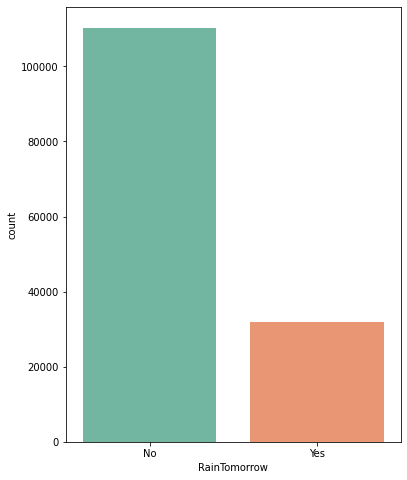

In [5]:
balance = widgets.ToggleButtons(
    options=['Oversampling', 'Oversampling Smote' ,'Subsampling','None'],
    description='Optios:',
    disabled=False,
    tooltips=['Oversampling', 'Oversampling Smote' ,'Subsampling', 'None']
)
print("Balanceig de les dades")
balance

Balanceig de les dades


ToggleButtons(description='Optios:', options=('Oversampling', 'Oversampling Smote', 'Subsampling', 'None'), to…

In [6]:
count_class_0, count_class_1 = database.RainTomorrow.value_counts()
if(balance.value == 'Oversampling'):
    df_class_0 = database[database['RainTomorrow'] == "No"]
    df_class_1 = database[database['RainTomorrow'] == "Yes"]
    
    df_class_1_over = df_class_1.sample(count_class_0, replace=True)
    database = pd.concat([df_class_0, df_class_1_over], axis=0)
    
elif(balance.value == 'Subsampling'):
    df_class_0 = database[database['RainTomorrow'] == "No"]
    df_class_1 = database[database['RainTomorrow'] == "Yes"]

    df_class_0_under = df_class_0.sample(count_class_1)
    database = pd.concat([df_class_0_under, df_class_1], axis=0)
database['RainTomorrow'] = [1 if i=='Yes' else 0 for i in database['RainTomorrow'] ]

In [ ]:
if balance.value != 'Oversampling Smote' and balance.value != 'None':
    f, ax = plt.subplots(figsize=(6, 8))
    ax = sns.countplot(x="RainTomorrow", data=database, palette="Set2")
    plt.show()

In [6]:
x=database.drop(['RainTomorrow'],axis=1)
y=database['RainTomorrow']
print(x.shape,y.shape)

(220632, 21) (220632,)


In [7]:
categorical_cols = list(x.select_dtypes(include=['object']).columns)
continuous_cols = list(x.select_dtypes(include=['float64']).columns)

atributeNulls = widgets.ToggleButtons(
    options=['Mode', 'Median', 'Mean'],
    description='Optios:',
    disabled=False,
    tooltips=['Mode', 'Median', 'Mean']
)
display(atributeNulls)

ToggleButtons(description='Optios:', options=('Mode', 'Median', 'Mean'), tooltips=('Mode', 'Median', 'Mean'), …

In [8]:
x=database.drop(['RainTomorrow'],axis=1)
for i in categorical_cols:
    x[i].fillna(x[i].mode()[0], inplace=True)

if(targetNulls.value == 'Mode'):
    for column in continuous_cols:
        x[column].fillna(x[column].mode()[0], inplace = True)

elif(targetNulls.value == 'Median'):

    for column in continuous_cols:
        x[column].fillna(x[column].median(), inplace = True)
else:
    for column in continuous_cols:
        x[column].fillna(x[column].mean(), inplace = True)
print("Opcio escollida per als atribusc continues:", atributeNulls.value)
print("--------------------------------------")
    

Opcio escollida per als atribusc continues: Mode
--------------------------------------


In [9]:
transformer = ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse='False',drop='first'), categorical_cols)],remainder='passthrough')
x=transformer.fit_transform(x)

In [10]:
transformer.named_transformers_['ohe'].get_feature_names()

array(['x0_Albany', 'x0_Albury', 'x0_AliceSprings', 'x0_BadgerysCreek',
       'x0_Ballarat', 'x0_Bendigo', 'x0_Brisbane', 'x0_Cairns',
       'x0_Canberra', 'x0_Cobar', 'x0_CoffsHarbour', 'x0_Dartmoor',
       'x0_Darwin', 'x0_GoldCoast', 'x0_Hobart', 'x0_Katherine',
       'x0_Launceston', 'x0_Melbourne', 'x0_MelbourneAirport',
       'x0_Mildura', 'x0_Moree', 'x0_MountGambier', 'x0_MountGinini',
       'x0_Newcastle', 'x0_Nhil', 'x0_NorahHead', 'x0_NorfolkIsland',
       'x0_Nuriootpa', 'x0_PearceRAAF', 'x0_Penrith', 'x0_Perth',
       'x0_PerthAirport', 'x0_Portland', 'x0_Richmond', 'x0_Sale',
       'x0_SalmonGums', 'x0_Sydney', 'x0_SydneyAirport', 'x0_Townsville',
       'x0_Tuggeranong', 'x0_Uluru', 'x0_WaggaWagga', 'x0_Walpole',
       'x0_Watsonia', 'x0_Williamtown', 'x0_Witchcliffe', 'x0_Wollongong',
       'x0_Woomera', 'x1_ENE', 'x1_ESE', 'x1_N', 'x1_NE', 'x1_NNE',
       'x1_NNW', 'x1_NW', 'x1_S', 'x1_SE', 'x1_SSE', 'x1_SSW', 'x1_SW',
       'x1_W', 'x1_WNW', 'x1_WSW', 'x2

In [ ]:
if balance.value == 'Oversampling Smote':
    smote=SMOTE()
    x,y=smote.fit_resample(x,y)

    print(x.shape,y.shape)


In [11]:
x=pd.DataFrame(x.toarray())
def check_skewness(x):
    
    skew_limit=0.75
    skew_value=x[x.columns].skew()
    skew_cols=skew_value[abs(skew_value)>skew_limit]
    #print(skew_cols)
    cols=skew_cols.index
    return cols
    
skewed_col=check_skewness(x)
print(skewed_col)

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
             13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
             26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
             39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
             52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
             65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
             78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
             91,  92,  93,  96,  97,  99, 100, 107],
           dtype='int64')


In [12]:
pt=PowerTransformer(standardize=False)
x[skewed_col]=pt.fit_transform(x[skewed_col])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(176505, 110)
(44127, 110)
(176505,)
(44127,)


In [15]:
skewed_col=check_skewness(X_train)
print(skewed_col)
pt=PowerTransformer(standardize=False)
X_train[skewed_col]=pt.fit_transform(X_train[skewed_col])


Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87, 88, 89, 90, 91, 92, 93],
           dtype='int64')


<ipython-input-15-6c3f26e54231>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[skewed_col]=pt.fit_transform(X_train[skewed_col])
C:\Users\ricar.LAPTOP-D6I7L1KP\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\ricar.LAPTOP-D6I7L1KP\anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

In [16]:
skewed_col=check_skewness(X_test)
print(skewed_col)
pt=PowerTransformer(standardize=False)
X_test[skewed_col]=pt.fit_transform(X_test[skewed_col])

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87, 88, 89, 90, 91, 92, 93],
           dtype='int64')


<ipython-input-16-9dde1dfdbdf4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[skewed_col]=pt.fit_transform(X_test[skewed_col])
C:\Users\ricar.LAPTOP-D6I7L1KP\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\ricar.LAPTOP-D6I7L1KP\anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

In [17]:
sc=StandardScaler(with_mean=False)
sc=sc.fit(X_train)
X_train=sc.transform(X_train)
X_test=sc.transform(X_test)

In [25]:
from matplotlib import pyplot
def evaluate(model):
    inicio = time.time()
    model.fit(X_train,y_train)
    tempsTrigat = time.time()- inicio
    y_pred = model.predict(X_test)
    lr_probs  = model.predict_proba(X_test)
    print('-------------------- ')
    print('model name ',model)
    print('accuracy: ',accuracy_score(y_test, y_pred))
    print("Recall: ", recall_score(y_test, y_pred))
    print("Precision: ", precision_score(y_test, y_pred))
    print('F1_score;', f1_score(y_test, y_pred, average='macro'))
    print("Temps:", tempsTrigat )
    print('-------------------- ')
    
#     ns_probs = [0 for _ in range(len(y_test))]
#     lr_probs = lr_probs[:, 1]
#     ns_auc = roc_auc_score(y_test, ns_probs)
#     lr_auc = roc_auc_score(y_test, lr_probs)
#     ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
#     lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
#     # Pintamos las curvas ROC
#     pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
#     pyplot.plot(lr_fpr, lr_tpr, marker='.', label=model)
#     # Etiquetas de los ejes
#     pyplot.xlabel('Tasa de Falsos Positivos')
#     pyplot.ylabel('Tasa de Verdaderos Positivos')
#     pyplot.title(model)
#     pyplot.legend()
#     pyplot.show()
   
    
lr=LogisticRegression()
svm=SVC()
dt=DecisionTreeClassifier(max_depth=6)
rf=RandomForestClassifier(max_samples=0.9)
xgbc = XGBClassifier(objective='binary:logistic', random_state=0)
knn=KNeighborsClassifier(n_neighbors=5)

models=[lr,dt,rf,xgbc,knn]

for model in models:
    evaluate(model)


C:\Users\ricar.LAPTOP-D6I7L1KP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


model name  LogisticRegression()
accuracy:  0.7861400049856098
Recall:  0.7749808273559796
Precision:  0.794294433142223
F1_score; 0.7861278984049722
Temps: 5.389533758163452
model name  DecisionTreeClassifier(max_depth=6)
accuracy:  0.7663335372900945
Recall:  0.7757928452203726
Precision:  0.7630224509716923
F1_score; 0.7662934397458855
Temps: 3.3547701835632324
model name  RandomForestClassifier(max_samples=0.9)
accuracy:  0.9472885081696014
Recall:  0.978481526593585
Precision:  0.9214495093249501
F1_score; 0.9472209283229661
Temps: 56.47921919822693


C:\Users\ricar.LAPTOP-D6I7L1KP\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
model name  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
accuracy:  0.8359961021596755
Recall:  0.8381828844679028
Pre

In [ ]:
rf=RandomForestClassifier()
distributions ={
    'n_estimators':[25,50,75,100],
    'criterion':["gini", "entropy"], 
    'max_features':["sqrt", "log2"],
    'bootstrap':[True, False],
    'max_samples':[0.3,0.5,0.7,0.9]
    
}
clf = RandomizedSearchCV(rf, distributions, random_state=42)
search = clf.fit(X_train, y_train)
print(search.best_params_)

In [ ]:
rf=RandomForestClassifier(n_estimators= 50, max_samples= 0.3, max_features='log2', criterion= 'gini', bootstrap= False)
inicio = time.time()
rf.fit(X_train,y_train)
tempsTrigat = time.time()- inicio
y_pred = rf.predict(X_test)

print('accuracy: ',accuracy_score(y_test, y_pred))
#print("Recall: ", recall_score(y_test, y_pred))
print('F1_score;', f1_score(y_test, y_pred, average='macro'))
print("Temps:", tempsTrigat )

C:\Users\ricar.LAPTOP-D6I7L1KP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ricar.LAPTOP-D6I7L1KP\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:15:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


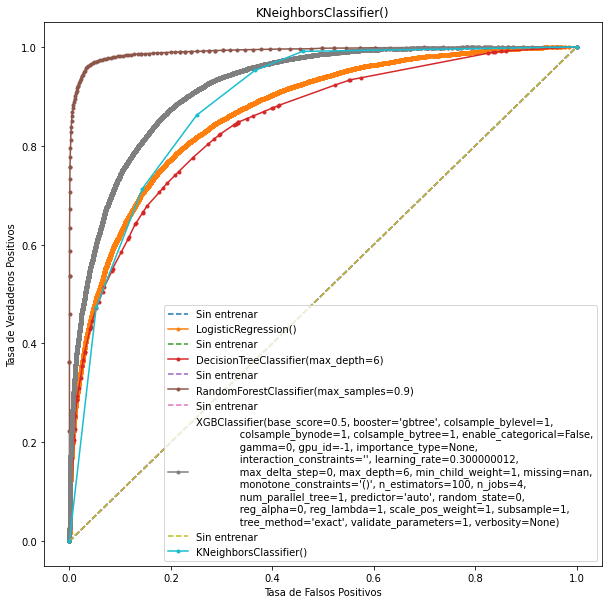

In [34]:
lr=LogisticRegression()
svm=SVC()
dt=DecisionTreeClassifier(max_depth=6)
rf=RandomForestClassifier(max_samples=0.9)
xgbc = XGBClassifier(objective='binary:logistic', random_state=0)
knn=KNeighborsClassifier(n_neighbors=5)

models=[lr,dt,rf,xgbc,knn]
count = 1
plt.figure(figsize=(10, 10))
ns_probs = [0 for _ in range(len(y_test))]
for model in models:
    model.fit(X_train,y_train)
    lr_probs  = model.predict_proba(X_test)
   
    
    lr_probs = lr_probs[:, 1]
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # Pintamos las curvas ROC
    if(count ==1):
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model)
    # Etiquetas de los ejes
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(model)
pyplot.legend()
pyplot.show()

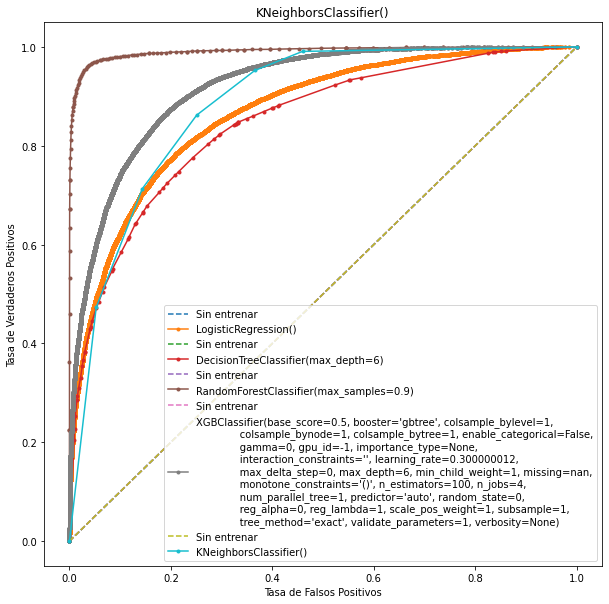